# Generate Faces using DCGAN

In [13]:
import os
import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import time
import math

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
import numpy as np
import pickle

In [14]:
def time_since(start):
    now = time.time()
    s = now - start
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [15]:
data_path = "/Users/dhoomilbsheta/Development/datasets/lfw-deepfunneled"

epochs = 10 # Set low by default for tests, set higher when you actually run this code.
batch_size = 64
latent_z_size = 100

use_gpu = False
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.0002
beta1 = 0.5

### Preprocess the LWF Face Dataset

In [30]:
img_dims = 64
img_list = []

def transform(data, dims):
    data = mx.image.imresize(data, dims, dims)
    data = nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, img_dims)
        img_list.append(img_arr)
        
with open("faces_dataset_processed.pkl", "wb") as f:
    pickle.dump(img_list, f)

### Load Data

In [16]:
with open("faces_dataset_processed.pkl", "rb") as f:
    img_list = pickle.load(f)

In [17]:
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size, shuffle=True)

In [18]:
train_data.provide_data

[DataDesc[data,(64, 3, 64, 64),<class 'numpy.float32'>,NCHW]]

### Visualise some images

In [11]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

# for i in range(4):
#     plt.subplot(1,4,i+1)
#     visualize(img_list[i + 10][0])
# plt.show()

## DCGAN Architecture
The core to the DCGAN architecture uses a standard CNN architecture on the discriminative model. For the generator, convolutions are replaced with upconvolutions, so the representation at each layer of the generator is actually successively larger, as it mapes from a low-dimensional latent vector onto a high-dimensional image.

1. Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
2. Use batch normalization in both the generator and the discriminator.
3. Remove fully connected hidden layers for deeper architectures.
4. Use ReLU activation in generator for all layers except for the output, which uses Tanh.
5. Use LeakyReLU activation in the discriminator for all layers.


### Build the generator

In [4]:
n_channels = 3
n_filters_g = 64
generator = nn.HybridSequential()
with generator.name_scope():
    # input is Z, going into a convolution
    generator.add(nn.Conv2DTranspose(n_filters_g * 8, 4, 1, 0, use_bias=False))
    generator.add(nn.BatchNorm())
    generator.add(nn.Activation('relu'))
    # state size. (n_filters_g*8) x 4 x 4
    generator.add(nn.Conv2DTranspose(n_filters_g * 4, 4, 2, 1, use_bias=False))
    generator.add(nn.BatchNorm())
    generator.add(nn.Activation('relu'))
    # state size. (n_filters_g*8) x 8 x 8
    generator.add(nn.Conv2DTranspose(n_filters_g * 2, 4, 2, 1, use_bias=False))
    generator.add(nn.BatchNorm())
    generator.add(nn.Activation('relu'))
    # state size. (n_filters_g*8) x 16 x 16
    generator.add(nn.Conv2DTranspose(n_filters_g, 4, 2, 1, use_bias=False))
    generator.add(nn.BatchNorm())
    generator.add(nn.Activation('relu'))
    # state size. (n_filters_g*8) x 32 x 32
    generator.add(nn.Conv2DTranspose(n_channels, 4, 2, 1, use_bias=False))
    generator.add(nn.Activation('tanh'))
    # state size. (nc) x 64 x 64

### Build the generator

In [5]:
n_filters_d = 64
discriminator = nn.HybridSequential()
with discriminator.name_scope():
    # input is (nc) x 64 x 64
    discriminator.add(nn.Conv2D(n_filters_d, 4, 2, 1, use_bias=False))
    discriminator.add(nn.LeakyReLU(0.2))
    # state size. (n_filters_d) x 32 x 32
    discriminator.add(nn.Conv2D(n_filters_d * 2, 4, 2, 1, use_bias=False))
    discriminator.add(nn.BatchNorm())
    discriminator.add(nn.LeakyReLU(0.2))
    # state size. (n_filters_d) x 16 x 16
    discriminator.add(nn.Conv2D(n_filters_d * 4, 4, 2, 1, use_bias=False))
    discriminator.add(nn.BatchNorm())
    discriminator.add(nn.LeakyReLU(0.2))
    # state size. (n_filters_d) x 8 x 8
    discriminator.add(nn.Conv2D(n_filters_d * 8, 4, 2, 1, use_bias=False))
    discriminator.add(nn.BatchNorm())
    discriminator.add(nn.LeakyReLU(0.2))
    # state size. (n_filters_d) x 4 x 4
    discriminator.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))


In [51]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
generator.initialize(mx.init.Normal(0.02), ctx=ctx)
discriminator.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(generator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(discriminator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

### Training

In [52]:
real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()

metric = mx.metric.CustomMetric(facc)

In [76]:
def train(epochs):
    print(f"Training for {epochs} epochs...")
    start = time.time()
    for epoch in range(epochs):
        train_data.reset()
        iteration = 0
        for batch in train_data:
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            data = batch.data[0].as_in_context(ctx)
            latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

            with autograd.record():
                # train with real image
                output = discriminator(data).reshape((-1, 1))
                errD_real = loss(output, real_label)
                metric.update([real_label,], [output,])

                # train with fake image
                fake = generator(latent_z)
                output = discriminator(fake).reshape((-1, 1))
                errD_fake = loss(output, fake_label)
                errD = errD_real + errD_fake
                errD.backward()
                metric.update([fake_label,], [output,])

            trainerD.step(batch.data[0].shape[0])

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            with autograd.record():
                fake = generator(latent_z)
                output = discriminator(fake).reshape((-1, 1))
                errG = loss(output, real_label)
                errG.backward()

            trainerG.step(batch.data[0].shape[0])

            if iteration % 50 == 0:
                name, acc = metric.get()
                print(f'epoch {epoch}: iter {iteration} d_loss = {nd.mean(errD).asscalar()}, generator loss = {nd.mean(errG).asscalar()}, training acc = {acc}')

            iteration = iteration + 1
        print(f"Time: {time_since(start)}")
        name, acc = metric.get()
        metric.reset()
    print(f"Time: {time_since(start)}")

In [8]:
def vis():
    num_image = 12
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    step = 0.05
    for i in range(num_image):
        img = generator(latent_z)
        plt.subplot(3,4,i+1)
        visualize(img[0])
        latent_z += 0.05
    plt.show()

In [82]:
generator.save_params(filename="dcgan_g")
discriminator.save_params(filename="dcgan_d")

In [6]:
generator.load_params(filename="dcgan_g", ctx=ctx)
discriminator.load_params(filename="dcgan_d", ctx=ctx)
# train(10)

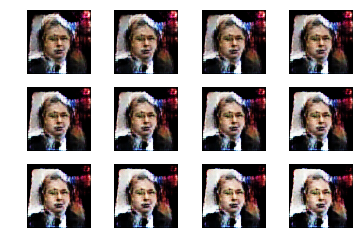

In [12]:
vis()